In [1]:
# multiclass classification
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv('df-climatechange.csv')
df = df.drop(['Unnamed: 0', 'qb1a'], axis = 1)
df['qb5'] = df['qb5'].replace({'No': 0, 'Yes':1})


#pd.set_option('display.max_columns', None)
df1 = df[df.qb2 >= 6]
df2 = df[df.qb2 <= 5]


In [2]:
#set parameters to search
parameters =    {
            'max_depth': [3, 4, 5],
            'learning_rate':  [0.1, 0.25, 0.5, 0.75, 1],
            'n_estimators': [50, 100, 150],
            'gamma': [0.5, 1, 1.5, 2],
            'min_child_weight': [1, 5, 10], 
            }




In [15]:
cc_num = df[['qb5', 'qb2', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7', 'k-means']]
cat_var =['d1','d10', 'country','d8','d25', 'd63','d7', 'k-means']


#cc_num = df[['qb5', 'qb2', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]
#cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']

df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 50 # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed,stratify=y)

In [16]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43631197, 0.76700502])

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune, with class weight 
gb =xgb.XGBClassifier( class_weight={0: 1.43631197 , 1:0.76700502})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_classifier = RandomizedSearchCV(gb, parameters, cv = 3, n_jobs = -1)
# Fit the random search model
gb_classifier.fit(X_train, y_train.values.ravel())


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(class_weight={0: 1.43631197,
                                                         1: 0.76700502}),
                   n_jobs=-1,
                   param_distributions={'gamma': [0.5, 1, 1.5, 2],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75,
                                                          1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 150]})

In [18]:
print(gb_classifier.best_params_)
print(gb_classifier.best_estimator_)


{'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.25, 'gamma': 1}
XGBClassifier(class_weight={0: 1.43631197, 1: 0.76700502}, gamma=1,
              learning_rate=0.25, max_depth=4, n_estimators=50)


In [19]:
#I search manually for the scale_pos_weight parameters. In the model I put the found parameters with GridSearch

lr_list = [0.1, 0.25, 0.5, 0.75, 1]
for weight in lr_list:
    gb_clf = xgb.XGBClassifier(n_estimators=50, learning_rate=0.25, max_depth=4, random_state=seed,  scale_pos_weight=weight, class_weight={0: 1.43631197 , 1:0.76700502}, min_child_weight= 1, gamma = 1)
    gb_clf.fit(X_train,  y_train.values.ravel())
    print('scale_pos_weight: ' , weight)
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test.values.ravel())))

scale_pos_weight:  0.1
Accuracy score (validation): 0.402
scale_pos_weight:  0.25
Accuracy score (validation): 0.542
scale_pos_weight:  0.5
Accuracy score (validation): 0.670
scale_pos_weight:  0.75
Accuracy score (validation): 0.707
scale_pos_weight:  1
Accuracy score (validation): 0.710


In [21]:
#choose scale_pos_weight = 0.75
gb_classifier = xgb.XGBClassifier(n_estimators=50, learning_rate=0.25, max_depth=4, random_state=seed,  scale_pos_weight=0.75, class_weight={0: 1.43631197 , 1:0.76700502}, min_child_weight= 1, gamma = 1)

gb_classifier.fit(X_train,  y_train.values.ravel())
predictions = gb_classifier.predict(X_test)


target_names = ['No action', 'Yes action']
print(classification_report(y_test, gb_classifier.predict(X_test),target_names=target_names))

              precision    recall  f1-score   support

   No action       0.59      0.50      0.54      2548
  Yes action       0.75      0.82      0.78      4771

    accuracy                           0.71      7319
   macro avg       0.67      0.66      0.66      7319
weighted avg       0.70      0.71      0.70      7319



Text(0.5, 15.0, 'Predicted label')

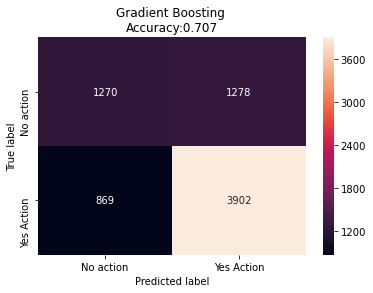

In [22]:
ac = accuracy_score(y_test,gb_classifier.predict(X_test))
#print('Accuracy is: ',ac)

#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,gb_classifier.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Gradient Boosting \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, gb_classifier.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

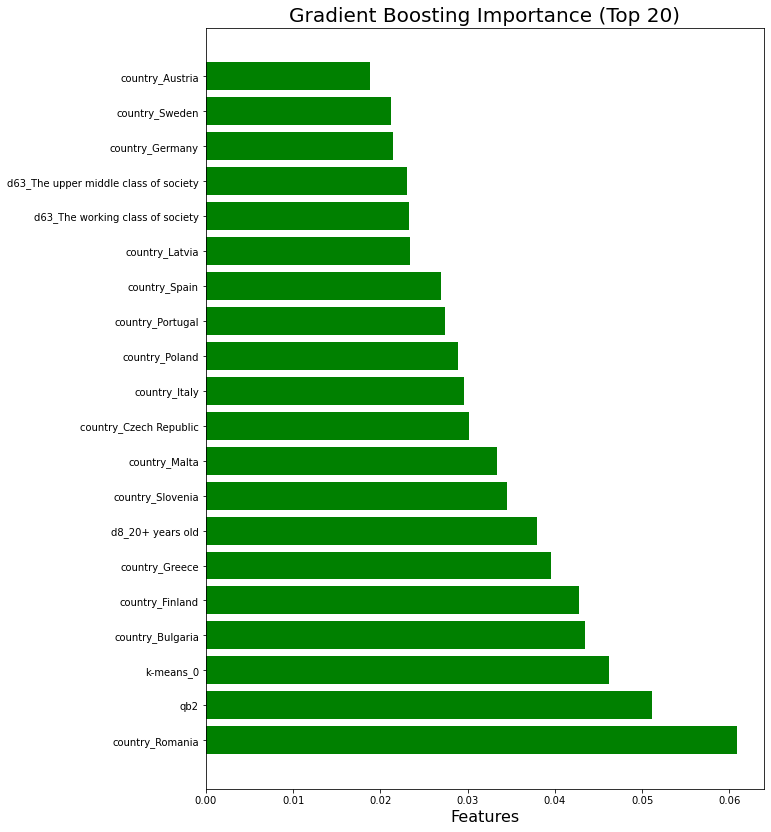

In [23]:
feature_importances = list(zip(X_train, gb_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Gradient Boosting Importance (Top 20)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


roc_auc_score for Gradient Boosting - High Risk Perception:  0.7383259649892882


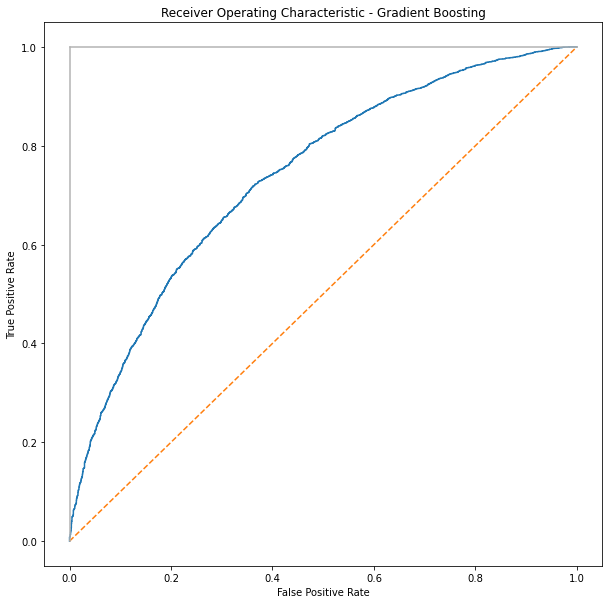

In [15]:
y_score2 = gb_classifier.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Gradient Boosting - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### High Risk Perception


In [49]:

cc_num = df1[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','k-means', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','k-means', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed,stratify=y)

In [25]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.56739773, 0.73421448])

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb =xgb.XGBClassifier( class_weight={0: 1.56739773 , 1:0.73421448})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_classifier = RandomizedSearchCV(gb, parameters, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
gb_classifier.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(class_weight={0: 1.56739773,
                                                         1: 0.73421448}),
                   n_jobs=-1,
                   param_distributions={'gamma': [0.5, 1, 1.5, 2],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75,
                                                          1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   verbose=2)

In [27]:
gb_classifier.best_params_

{'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.25,
 'gamma': 1}

In [28]:
#I search manually for the scale_pos_weight and learning rate parameters. In the model I put the found parameters with GridSearch

lr_list = [0.1, 0.25, 0.5, 0.75, 1]
for learning in lr_list: 
    for weight in lr_list:
        gb_clf = xgb.XGBClassifier(n_estimators=150, learning_rate=learning, gamma = 1, max_depth=4, random_state=seed ,  scale_pos_weight=weight, class_weight={0: 1.56739773 , 1:0.73421448}, min_child_weight= 1)
        gb_clf.fit(X_train,  y_train.values.ravel())
        print('scale_pos_weight: ' , weight)
        print('learning rate: ' , learning)
        print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test.values.ravel())))

scale_pos_weight:  0.1
learning rate:  0.1
Accuracy score (validation): 0.370
scale_pos_weight:  0.25
learning rate:  0.1
Accuracy score (validation): 0.519
scale_pos_weight:  0.5
learning rate:  0.1
Accuracy score (validation): 0.675
scale_pos_weight:  0.75
learning rate:  0.1
Accuracy score (validation): 0.717
scale_pos_weight:  1
learning rate:  0.1
Accuracy score (validation): 0.718
scale_pos_weight:  0.1
learning rate:  0.25
Accuracy score (validation): 0.374
scale_pos_weight:  0.25
learning rate:  0.25
Accuracy score (validation): 0.535
scale_pos_weight:  0.5
learning rate:  0.25
Accuracy score (validation): 0.670
scale_pos_weight:  0.75
learning rate:  0.25
Accuracy score (validation): 0.709
scale_pos_weight:  1
learning rate:  0.25
Accuracy score (validation): 0.717
scale_pos_weight:  0.1
learning rate:  0.5
Accuracy score (validation): 0.401
scale_pos_weight:  0.25
learning rate:  0.5
Accuracy score (validation): 0.548
scale_pos_weight:  0.5
learning rate:  0.5
Accuracy score 

#### Best Model

In [50]:
#choose learning rate 0.5 scale_pos_weight = 0.5
gb_classifier =xgb.XGBClassifier(n_estimators=150, learning_rate=0.5, gamma = 1, max_depth=4, random_state=seed ,  scale_pos_weight=0.5, class_weight={0: 1.56739773 , 1:0.73421448}, min_child_weight= 1)
gb_classifier.fit(X_train, y_train)
predictions = gb_classifier.predict(X_test)

target_names = ['No action', 'Yes action']
print(classification_report(y_test, gb_classifier.predict(X_test),target_names=target_names))

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

   No action       0.49      0.60      0.54      2026
  Yes action       0.79      0.70      0.74      4325

    accuracy                           0.67      6351
   macro avg       0.64      0.65      0.64      6351
weighted avg       0.69      0.67      0.68      6351



Text(0.5, 15.0, 'Predicted label')

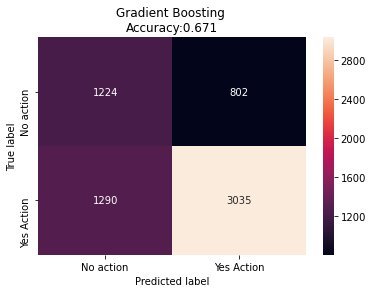

In [51]:
ac = accuracy_score(y_test,gb_classifier.predict(X_test))
#print('Accuracy is: ',ac)

#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,gb_classifier.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Gradient Boosting \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, gb_classifier.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

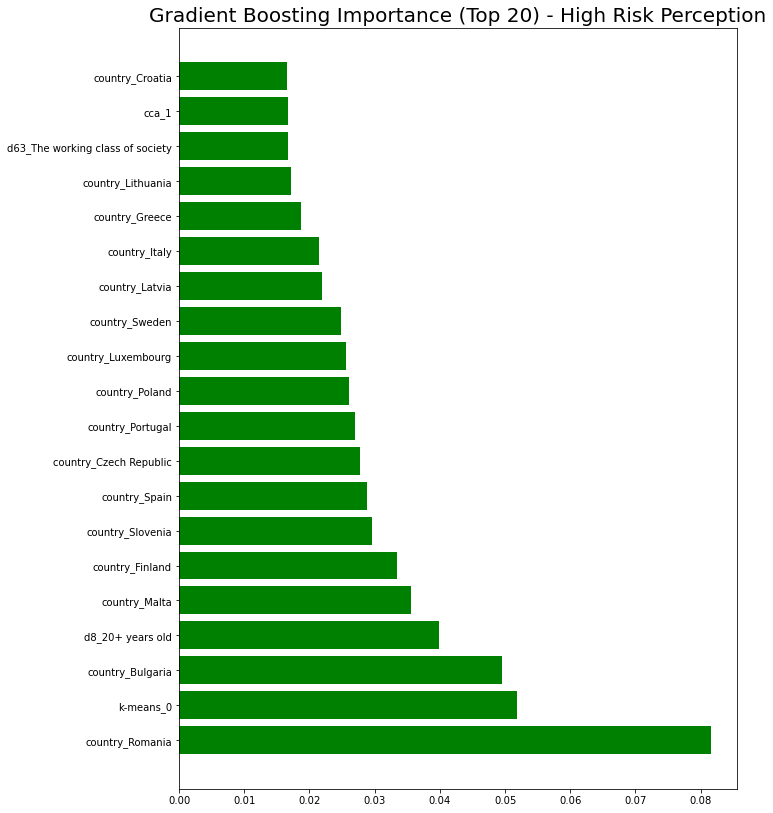

In [53]:
feature_importances = list(zip(X_train, gb_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Gradient Boosting Importance (Top 20) - High Risk Perception',
          fontdict= {'fontsize' : 20})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


roc_auc_score for Gradient Boosting - High Risk Perception:  0.7042985124023532


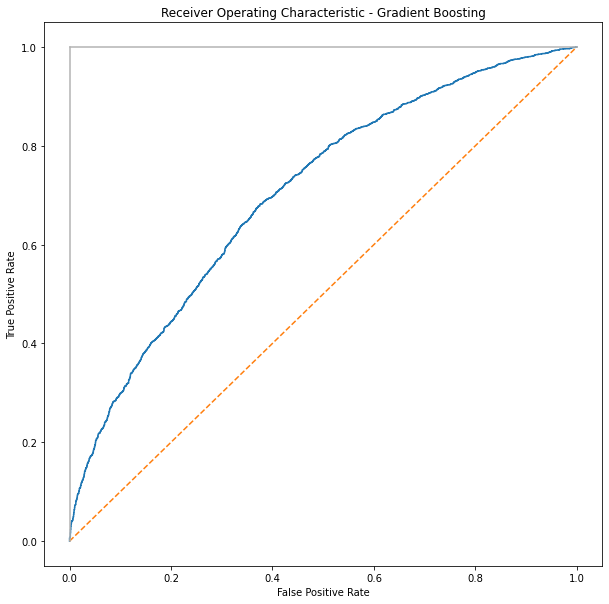

In [58]:
y_score2 = gb_classifier.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Gradient Boosting - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Low Risk Perception 


In [40]:

cc_num = df2[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','k-means', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','k-means', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed,stratify=y)

In [41]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([0.92727273, 1.08510638])

In [43]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb =xgb.XGBClassifier( class_weight={0: 0.92727273 , 1:1.08510638})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_classifier = RandomizedSearchCV(gb, parameters, cv = 3, verbose=2, n_jobs = -1, random_state = seed)
# Fit the random search model
gb_classifier.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(class_weight={0: 0.92727273,
                                                         1: 1.08510638}),
                   n_jobs=-1,
                   param_distributions={'gamma': [0.5, 1, 1.5, 2],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75,
                                                          1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=50, verbose=2)

In [45]:
gb_classifier.best_params_

{'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 2}

In [46]:
#Learning rate:  0.5 #scale_pos_weight:  0.5
gb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1 , class_weight={0: 0.92727273 , 1:1.08510638}, min_child_weight =5, max_depth=3, gamma = 2,  random_state=seed)
gb_classifier.fit(X_train, y_train)
predictions = gb_classifier.predict(X_test)


target_names = ['No action', 'Yes action']
print(classification_report(y_test, gb_classifier.predict(X_test),target_names=target_names))

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

   No action       0.66      0.71      0.68       522
  Yes action       0.63      0.57      0.60       446

    accuracy                           0.65       968
   macro avg       0.64      0.64      0.64       968
weighted avg       0.65      0.65      0.65       968



Text(0.5, 15.0, 'Predicted label')

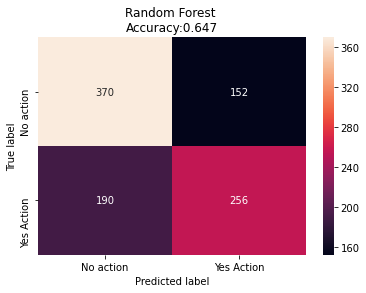

In [47]:
ac = accuracy_score(y_test,gb_classifier.predict(X_test))
#print('Accuracy is: ',ac)



#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,gb_classifier.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, gb_classifier.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

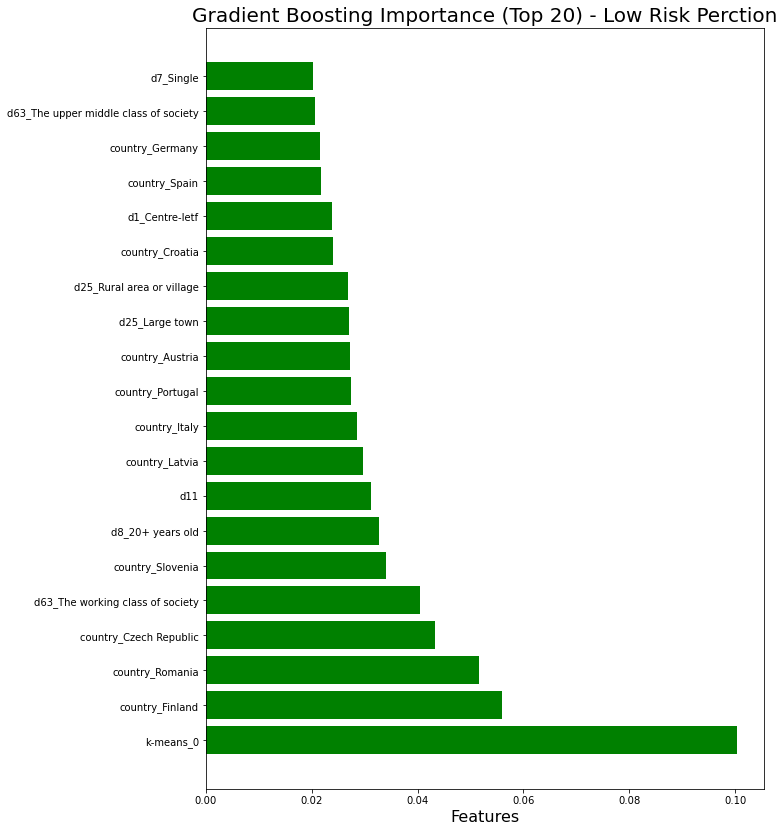

In [48]:
feature_importances = list(zip(X_train, gb_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Gradient Boosting Importance (Top 20) - Low Risk Perction',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

roc_auc_score for Gradient Boosting - High Risk Perception:  0.7044997680531933


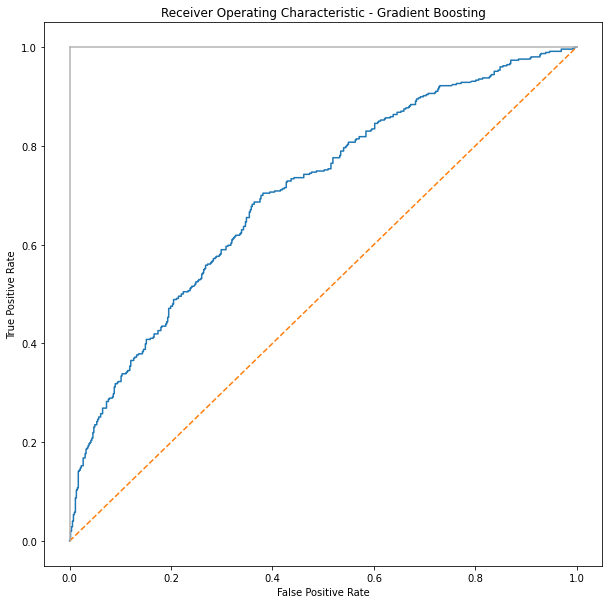

In [89]:
y_score2 = gb_classifier.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Gradient Boosting - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REFERENCES

https://www.kaggle.com/henrylidgley/xgboost-with-hyperopt-tuning

https://stackoverflow.com/questions/54145714/grid-search-and-xgbclassifier-using-class-weights